# Florian Guillot & Julien Donche: Project 7
### Topic modeling and keywords extractions for Holi.io
### Jedha Full Stack, dsmf-paris-13
### 08-2021

This project is the final project as Jedha Students. 
Idea has been submitted by Holi.io Founder : Clément Sirvente
The specifications from Holi.io can be found [here](https://github.com/FlorianG-dev/Jedha_certification/blob/master/7_Holi/Project_initialization.pdf). It is the projet number 1 : Topic modeling

---

This notebook is the **first** notebook in a serie of two

# **1) Initialization**
----
## **1.1) We begin with the Import of the different libraries we will use and their configurations**
----

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import string
from itertools import product
from collections import defaultdict

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
#!spacy download en_core_web_sm -q
import en_core_web_sm

## **1.2) Data collection**
---

### We work on the Mind Dataset. You can find more information [here](https://msnews.github.io/)
First, we gather the data relative to the articles:

In [2]:
# The news.tsv file contains the detailed information of news articles involved in the behaviors.tsv file.
# It has 7 columns, which are divided by the tab symbol:
# - News ID
# - Category
# - Subcategory
# - Title
# - Abstract
# - URL
# - Title Entities (entities contained in the title of this news)
# - Abstract Entities (entities contained in the abstract of this news)
file_news = pd.read_table('Data/news.tsv',
              header=None,
              names=[
                  'id', 'category', 'subcategory', 'title', 'abstract', 'url',
                  'title_entities', 'abstract_entities'
              ])
file_news['nid']=file_news['url'].str[-12:-5] #The id of the articles are extracted from the URL

Then, we gather the content of these articles

In [5]:
json_news = pd.read_json('Data/msn-article_content.json')
json_news['text'] = [' '.join(x) for x in json_news['body']]
json_news = json_news.drop(['body'], axis=1)

In [6]:
print("Shape of the articles' content :",json_news.shape)
print("Shape of the articles' information :",file_news.shape)

Shape of the articles' content : (51282, 2)
Shape of the articles' information : (51282, 9)


We merge those files to create our dataset

In [8]:
raw_data = file_news.merge(json_news, on = 'nid').drop(['title_entities', 'abstract_entities', 'url', 'abstract'], axis=1)
raw_data.head()

,id,category,subcategory,title,nid,text
0,N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...",AAGH0ET,The royals are free to shop wherever they cho...
1,N19639,health,weightloss,50 Worst Habits For Belly Fat,AAB19MK,"When you first start dieting and exercising, t..."
2,N61837,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,AAJgNsz,"ZOLOTE, Ukraine — Lt. Ivan Molchanets peeked o..."
3,N53526,health,voices,I Was An NBA Wife. Here's How It Affected My M...,AACk2N6,I had to be perfect. In order to s...
4,N38324,health,medical,"How to Get Rid of Skin Tags, According to a De...",AAAKEkt,"As you get older, little growths called skin t..."


In [10]:
print("Shape of our dataset:",raw_data.shape)

Shape of our dataset: (51278, 6)


# **2) DEA**
---

## **2.1) Dataset Overview**
---

In [33]:
df = raw_data.copy() # We create our dataframe df
#df = raw_data.sample(1000).copy() #sample for testing

In [34]:
df.head()

,id,category,subcategory,title,nid,text
0,N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...",AAGH0ET,The royals are free to shop wherever they cho...
1,N19639,health,weightloss,50 Worst Habits For Belly Fat,AAB19MK,"When you first start dieting and exercising, t..."
2,N61837,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,AAJgNsz,"ZOLOTE, Ukraine — Lt. Ivan Molchanets peeked o..."
3,N53526,health,voices,I Was An NBA Wife. Here's How It Affected My M...,AACk2N6,I had to be perfect. In order to s...
4,N38324,health,medical,"How to Get Rid of Skin Tags, According to a De...",AAAKEkt,"As you get older, little growths called skin t..."


In [35]:
df.describe(include = 'all')

,id,category,subcategory,title,nid,text
count,51278,51278,51278,51278,51278,51278
unique,51278,17,264,50430,51278,50517
top,N55528,news,newsus,Photos of the Day,AAGH0ET,
freq,1,15774,6564,15,1,100


## **2.2) Deleting first outliers and duplicates**
---

In [36]:
df = df[df['text'].str.len()<20000].reset_index() #We remove the texts too long
df = df[df['text'].str.len()>30].reset_index() #We remove the texts too short
df = df.drop_duplicates(['text']) #We remove textx that appear multiple times
df = df.drop(['level_0','index'], axis=1)

## **2.3) Looking at punctuations**
---

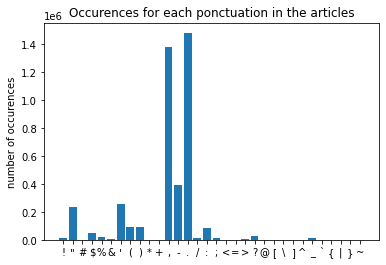

In [38]:
ponctuations = {x : 0 for x in string.punctuation}
for ponc,text in product(string.punctuation, df['text']):
  ponctuations[ponc] += text.count(ponc) 
x,y=zip(*ponctuations.items())
plt.figure()
plt.ylabel("number of occurences")
plt.title("Occurences for each ponctuation in the articles")
plt.bar(x,y)
plt.show()

## **2.4) Handling missing values**
---

In [39]:
df.isnull().value_counts()

id     category  subcategory  title  nid    text 
False  False     False        False  False  False    50004
dtype: int64

### **We do not have missing values in this dataset**

## **2.5) Text lenght**
---

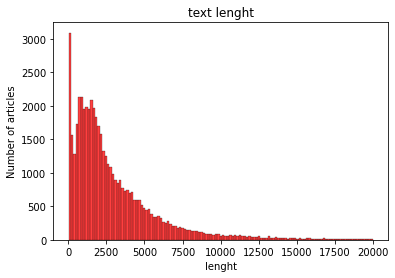

In [40]:
plt.figure()
ax = sns.histplot(df.text.str.len(),color='red')
ax.set (ylabel="Number of articles", 
        title ="text lenght", 
        xlabel = "lenght")
plt.show();

### **Most of texts are under 10 000 characters and a lot are under 100, we will need to take care of missing values after the tokenization**
We take a look at the short articles : 

In [42]:
df[df['text'].str.len()<100]

,id,category,subcategory,title,nid,text
143,N14176,foodanddrink,videos,Blueberry Dump Cake Satisfies Every Sweet Tooth,AABRsV7,"Dump cakes are the perfect, easy summer desser..."
152,N16430,video,animals,This Rare Albino Hedgehog Was Rescued In Calif...,AAHZ3Ph,This hedgehog was rescued in California.
273,N60467,video,animals,Puppy adorably escapes pen to join doggy friends,AAJgR3m,Watch this puppy make a hilarious escape from ...
354,N10220,video,viral,Boy With No Legs Goes Viral After Video of Him...,AAHtM4V,This 10-year old is fearless. Buzz60’s Tony Sp...
386,N48320,sports,football_nfl_videos,Denver Broncos quarterback Joe Flacco voices f...,AAJrGQp,Denver Broncos quarterback Joe Flacco voices f...
...,...,...,...,...,...,...
50477,N4908,lifestyle,lifestylefamily,Family of 100-year-old veteran never knew he w...,BBWyyCy,\r\nFamily of 100-year-old veteran never knew ...
50478,N45120,video,news,New worries for American held in Lebanon,BBWyyDx,\r\nThe plea to Pres. Trump from Amer Fakhoury...
50500,N33626,sports,football_nfl_videos,Ravens crush Bengals,BBWyyqH,\r\nWatch the highlights from the Week 10 matc...
50513,N32024,sports,football_nfl_videos,Dolphins force turnovers to beat Colts,BBWyzGK,\r\nWatch highlights from the Week 10 game bet...


# **3) Data cleaning**
---

## **3.1) Cleaning function**
---

### We create a function to clean the dataset. This functions has evolved during all the projects as much as we faced issues or wanted to transform more the text

In [44]:
def clean (article):

  # We force the utf-8 encoding
  article.encode("utf-8").decode("utf-8")
  
  # Deletes urls
  article = re.sub(r"https:[A-Za-z0-9]+", "", article)
  article = re.sub(r"http:[A-Za-z0-9]+", "", article)
  article = re.sub(r"www\.[A-Za-z0-9]+", "", article)
  
  # We delete the \r and the \n that are everywhere in the articles
  article = re.sub(r"\\r|\\n", "", article)
  
  #We delete the 's
  article = re.sub(r"'s", "", article)
  
  # We delete everything that is not alphabetic
  pattern = re.compile(r'[^a-zA-Z]+')
  article = pattern.sub(' ', article)
  
  # Transform multiples spaces in one space
  article = re.sub(r"\s{2,}", " ", article)

  # strip 
  article = article.strip()

  return article

And apply it to all our articles

In [46]:
%time df['text_cleaned'] = df['text'].apply(lambda s : clean(s))

Wall time: 9.98 s


## **3.2) Cleaning results**
---

We visualize the lenght of the articles, first for all the articles then for the little articles

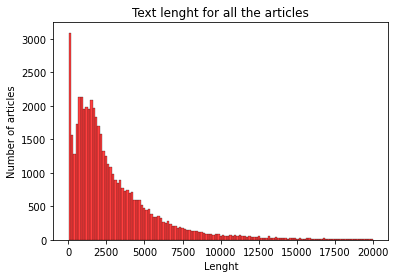

In [47]:
plt.figure()
ax = sns.histplot(df.text.str.len(),color='red')
ax.set (ylabel="Number of articles", 
        title ="Text lenght for all the articles", 
        xlabel = "Lenght")
plt.show();

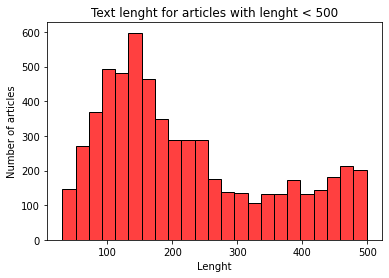

In [48]:
plt.figure()
ax = sns.histplot(df[df.text.str.len()<500].text.str.len(),color='red')
ax.set (ylabel="Number of articles", 
        title ="Text lenght for articles with lenght < 500", 
        xlabel = "Lenght")
plt.show();

Let's visualize the stop words in our cleaned dataset

Text(0, 0.5, 'Occurence in million')

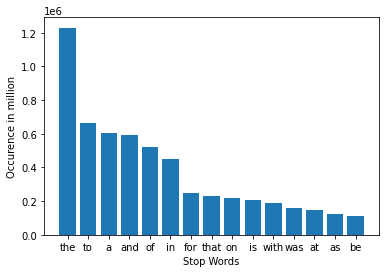

In [62]:
all_articles = df.text.str.cat(sep=' ').split() #One very long string with all the articles
dic=defaultdict(int)
for word in all_articles:
    if word in STOP_WORDS:
        dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:15]
x,y=zip(*top)
plt.bar(x,y)
plt.xlabel("Stop Words")
plt.ylabel("Occurence in million")

## **3.3) Lemmatization**
---

In [63]:
df.head()

,id,category,subcategory,title,nid,text,text_cleaned
0,N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...",AAGH0ET,The royals are free to shop wherever they cho...,The royals are free to shop wherever they choo...
1,N61837,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,AAJgNsz,"ZOLOTE, Ukraine — Lt. Ivan Molchanets peeked o...",ZOLOTE Ukraine Lt Ivan Molchanets peeked over ...
2,N53526,health,voices,I Was An NBA Wife. Here's How It Affected My M...,AACk2N6,I had to be perfect. In order to s...,I had to be perfect In order to shed my perfec...
3,N38324,health,medical,"How to Get Rid of Skin Tags, According to a De...",AAAKEkt,"As you get older, little growths called skin t...",As you get older little growths called skin ta...
4,N2073,sports,football_nfl,Should NFL be able to fine players for critici...,AAJ4lap,The officiating in the Packers' 23-22 Monday n...,The officiating in the Packers Monday night wi...


### We use a dic to replace common words with our empirical observations, this dic has evolved during the project

In [42]:
to_replace={
    'sen':'senate',
    'senator':'senate',
    'teacher':'teaching'
}

### We remove Stop Words, with empirical observations with LDA model and Bert words extractions, we complete the stop_words list 

In [43]:
add_stop_words={'tonight',
                'yes',
                'no',
                'hey',
                'okay',
                'etc',
                'mr',
                'mss',
                'ms',
                'er',
                'v',
                'monthly',
                'tb',
                'sec',
                'mind'}
STOP_WORDS |= add_stop_words

### Now we perform two actions on our articles :
### - Remove stop-words
### - Remove words which are not Noun, adjective or verb
### **Warning : very long, 3 000 seconds for the small dataset**

In [44]:
nlp = en_core_web_sm.load()
excluded_tags = {"ADV", "ADP", "AUX", "NUM"}

%time df['text_tokenized'] = df['text_cleaned'].apply(lambda x: [token.lemma_ for token in nlp(x) if (token.pos_ not in excluded_tags) & (token.lemma_.lower() not in STOP_WORDS) & (token.text.lower() not in STOP_WORDS) & (len(token.lemma_) >1)])
df['nlp_ready'] = df['text_tokenized'].str.join(' ').str.lower() # We replace the capitals letter
df = df.drop(['text_tokenized'], axis=1)
df = df.dropna() #The cleaning has created empty cells, we delete the rows accordingly
df.to_csv('Data/smallMind_clean_data_without_stop_words.csv', index=False) #We save our dataset to a csv file

In [45]:
df.head()

,id,category,subcategory,title,nid,text,text_cleaned,nlp_ready
0,N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...",AAGH0ET,The royals are free to shop wherever they cho...,The royals are free to shop wherever they choo...,royal free shop choose tend family royal warra...
1,N61837,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,AAJgNsz,"ZOLOTE, Ukraine — Lt. Ivan Molchanets peeked o...",ZOLOTE Ukraine Lt Ivan Molchanets peeked over ...,zolote ukraine lt ivan molchanets peek parapet...
2,N53526,health,voices,I Was An NBA Wife. Here's How It Affected My M...,AACk2N6,I had to be perfect. In order to s...,I had to be perfect In order to shed my perfec...,perfect order shed perfectionism know major li...
3,N38324,health,medical,"How to Get Rid of Skin Tags, According to a De...",AAAKEkt,"As you get older, little growths called skin t...",As you get older little growths called skin ta...,old little growth skin tag start pop body reco...
4,N2073,sports,football_nfl,Should NFL be able to fine players for critici...,AAJ4lap,The officiating in the Packers' 23-22 Monday n...,The officiating in the Packers Monday night wi...,officiating packers monday night win lions egr...


---

# **The next steps are in the notebook Step2_LDA_model_training**